In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import os
import category_encoders as ce
import statistics
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Сколько уникальных названий отелей представлено в наборе данных?

In [12]:
len(hotels['hotel_name'].unique())

1492

Меняем тип данных признака review_date на datetime64. Самый свежий отзыв 2017-08-03. Самый первый отзыв 2015-08-04

In [13]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print(hotels['review_date'].sort_values().head(1))
print(hotels['review_date'].sort_values().tail(1))

208558   2015-08-04
Name: review_date, dtype: datetime64[ns]
45365   2017-08-03
Name: review_date, dtype: datetime64[ns]


Кол-во уникальных тегов 2368

In [14]:
tage_cnt = {}
for i in hotels.tags:
    for j in i[2:-2].strip().split(' \', \' '):
        if j in tage_cnt:
            tage_cnt[j] += 1
        else:
            tage_cnt[j] = 1
print({len(tage_cnt)})

{2428}


Какой тег представлен в наибольшем числе отзывов?

In [15]:
# Определяем ТОП тегов
cnt = Counter() 
for i, row in hotels['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    cnt.update(tmp)
    
print(f'Количество уникальных тегов {len(list(cnt))}')
print(cnt.most_common(15))
most_tag = cnt.most_common(15) 

Количество уникальных тегов 2428
[('Leisure trip', 417778), ('Submitted from a mobile device', 307640), ('Couple', 252294), ('Stayed 1 night', 193645), ('Stayed 2 nights', 133937), ('Solo traveler', 108545), ('Stayed 3 nights', 95821), ('Business trip', 82939), ('Group', 65392), ('Family with young children', 61015), ('Stayed 4 nights', 47817), ('Double Room', 35207), ('Standard Double Room', 32248), ('Superior Double Room', 31393), ('Family with older children', 26349)]


Из тегов выясните, на сколько ночей чаще всего останавливаются путешественники в отелях.

In [16]:
regex = 'Stayed\s\d+'
hotels['count_nights'] = hotels['tags'].str.findall(regex).str.get(0)
#При отсутствии тега nights указываем 0
hotels['count_nights'] = hotels['count_nights'].fillna(0)
hotels['count_nights'].value_counts()

Stayed 1     193645
Stayed 2     133937
Stayed 3      95821
Stayed 4      47817
Stayed 5      20845
Stayed 6       9776
Stayed 7       7399
Stayed 8       2502
Stayed 9       1293
Stayed 10       889
Stayed 11       418
Stayed 12       316
Stayed 14       247
Stayed 13       246
0               192
Stayed 15       117
Stayed 16        57
Stayed 17        42
Stayed 18        33
Stayed 19        29
Stayed 21        23
Stayed 20        19
Stayed 27        11
Stayed 30        11
Stayed 23        10
Stayed 22        10
Stayed 25         7
Stayed 26         7
Stayed 28         7
Stayed 24         6
Stayed 29         5
Stayed 31         1
Name: count_nights, dtype: int64

Заполним пропуски в признаках lat и lng медианным значением

In [17]:
hotels[['lat', 'lng']] = hotels[['lat', 'lng']]. fillna(hotels[['lat', 'lng']].mean())

In [18]:
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace(' ', '').lower())
negative = hotels.groupby(by='negative_review', as_index=False).agg({'hotel_address': 'count'}).rename(columns={'hotel_address': 'count'}).sort_values(by='count', ascending=False)
negative[:25]

,negative_review,count
129127,nonegative,127890
135376,nothing,21272
117249,na,2087
129079,none,1501
0,,849
138050,nothingreally,657
194646,smallroom,570
28586,breakfast,550
9573,allgood,545
121774,nocomplaints,523


Видно, что в негативные отзывы попали и позитивные. Используем эту информацию и создадим новый признак - negative, со знчением 0 и 1 - негативный или позитивный отзыв

In [19]:
negative_rev = ['nonegative', 'nothing', 'na', 'none', '','nothingreally', 'allgood', 'nocomplaints', 'nothingatall', 
                'nothingtodislike', 'nil', 'everythingwasperfect', 'cantthinkofanything', 'absolutelynothing', 
                'everythingwasgreat', 'nothingtocomplainabout', 'everythingwasgood', 'no']
hotels['negative'] = hotels['negative_review'].apply(lambda x: 1 if x in negative_rev else 0)

Аналогично с положительными отзывами проделаем

In [20]:
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace(' ', '').lower())
positive = hotels.groupby(by='positive_review', as_index=False).agg({'hotel_address': 'count'}).rename(columns={'hotel_address': 'count'}).sort_values(by='count', ascending=False)
positive[:25]

,positive_review,count
216229,nopositive,35946
164907,location,11947
60366,everything,3550
216533,nothing,1758
116465,greatlocation,1688
304215,thelocation,1607
102042,goodlocation,1497
27167,breakfast,801
93691,friendlystaff,735
71945,excellentlocation,639


In [21]:
positive_rev = ['nopositive', 'nothing']
hotels['positive'] = hotels['positive_review'].apply(lambda x: 0 if x in positive_rev else 1)

Разберем дату

In [22]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

In [23]:
hotels.drop(columns=['review_date', 'negative_review', 'positive_review'], inplace=True)

Применим бинарное кодирование к признаку название отеля, всего значений 1492

In [24]:
bin_encoder = ce.BinaryEncoder()

data_code = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, data_code], axis=1)

hotels.drop(columns='hotel_name', inplace=True)

Преобразем признак days_since_review в числовой

In [25]:
def check_days(text):
    text_lst = text.split()
    return int(text_lst[0])

hotels['days_since_review'] = hotels['days_since_review'].apply(check_days)

In [26]:
#display(data[['review_year', 'review_month', 'winter', 'spring', 'summer', 'autumn', 'days_since_review']].corr())
display(hotels[['review_year', 'review_month', 'days_since_review']].corr())

,review_year,review_month,days_since_review
review_year,1.000000,-0.581331,-0.917266
review_month,-0.581331,1.000000,0.211014
days_since_review,-0.917266,0.211014,1.000000


Убираем признаки которые еще не успели обработать, 
Модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

In [27]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [28]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [29]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [30]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [31]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

In [32]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [33]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [34]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9405821810516062


<AxesSubplot:>

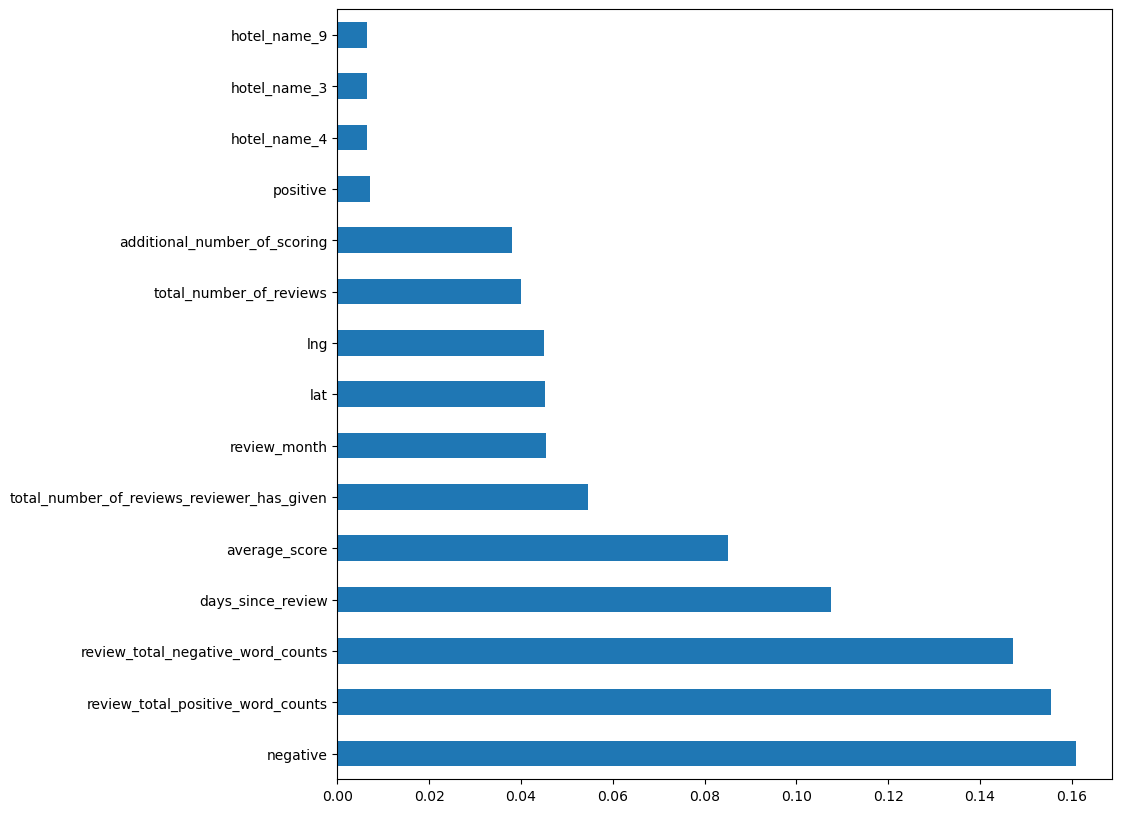

In [36]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [37]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
4778,354,8.3,14,1871,8,4,422,51.529860,-0.144462,0.0,...,0,0,1,0,1,1,0,1,0,0
115264,325,8.6,8,3221,2,6,310,48.206210,16.371039,0.0,...,0,1,0,1,0,1,0,1,1,0
22017,757,8.7,31,5236,9,2,691,52.357655,4.844576,0.0,...,0,1,1,1,1,0,1,1,1,0
112749,975,8.7,3,7656,20,1,660,52.354665,4.913164,0.0,...,0,1,1,1,1,0,0,1,0,0
20076,283,8.7,0,2678,4,1,420,45.484237,9.198858,0.0,...,0,1,1,1,1,0,0,0,1,1
953,211,9.3,19,1128,16,7,589,51.510092,-0.135943,0.0,...,1,0,0,0,1,0,1,1,0,1
62104,1427,8.8,9,4305,29,9,583,51.557696,-0.283526,0.0,...,1,0,1,0,1,0,0,1,1,0
73032,326,8.6,17,1032,7,12,566,51.475656,-0.181389,0.0,...,1,0,0,1,1,0,0,1,1,0
106196,168,8.2,9,1106,5,8,15,48.874715,2.290639,0.0,...,1,1,0,0,1,1,0,0,0,1
47349,317,7.6,26,1458,6,7,570,51.516114,-0.174952,0.0,...,0,0,1,0,1,1,1,1,1,1


In [38]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [39]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [40]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [41]:
predict_submission

array([8.505, 7.373, 8.161, ..., 8.142, 9.688, 6.667])

In [42]:
list(sample_submission)

['reviewer_score', 'id']

In [43]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.505,488440
1,7.373,274649
2,8.161,374688
3,9.526,404352
4,9.676,451596
5,8.746,302161
6,7.882,317079
7,7.291,13963
8,8.685,159785
9,8.111,195089
